In [2]:
import tqdm, torch, json, pickle, os, gc, time, sys
sys.path.append('../')
import pandas as pd
import numpy as np
from collections import OrderedDict
from src.utils.dataset import FPolyDatasetV2, collate_fn
from src.utils.data import CrossValidation
from src.utils.visualization import plot_scatter
from torch_geometric.nn import global_add_pool, global_max_pool, global_mean_pool
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import seaborn as sns
from pathlib import Path
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
# XGBoost, SVR, and GPR

/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


 - objective functions

In [24]:
def xgb_obj_fnc(eta, max_depth):
    global train_data, valid_data, test_data, m_best, best
    params = {
        'max_depth':int(np.round(max_depth)),
        'min_child_weight': 2,
        'eta':eta,
        # Other parameters
        'objective':'reg:squarederror',
        'eval_metric':'mae'
    }
    booster = xgb.train(params, dtrain=train_data, num_boost_round=100, early_stopping_rounds=5, 
                        evals=[(valid_data, 'valid')], verbose_eval=False)
    y_train = train_data.get_label()
    y_valid = valid_data.get_label()
    p_train = booster.predict(train_data, iteration_range=(0, booster.best_iteration+1))
    p_valid = booster.predict(valid_data, iteration_range=(0, booster.best_iteration+1))
    train_r2, train_mae = r2_score(y_train.reshape(-1), p_train), mean_absolute_error(y_train.reshape(-1), p_train)
    valid_r2, valid_mae = r2_score(y_valid.reshape(-1), p_valid), mean_absolute_error(y_valid.reshape(-1), p_valid)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        m_best = m
        y_test = test_data.get_label()
        p_test = booster.predict(test_data, iteration_range=(0, booster.best_iteration+1))
        test_r2, test_mae = r2_score(test_tgt.reshape(-1), p_test), mean_absolute_error(test_tgt.reshape(-1), p_test)
        best = {'params':params, 'train':[y_train, p_train], 'valid':[y_valid, p_valid], 'test':[y_test, p_test],
                'measure':[train_r2, train_mae, valid_r2, valid_mae, test_r2, test_mae]}
    return m

def svr_obj_fnc1(c, eps):
    global x_train, x_valid, y_train, y_valid, test_feat, test_tgt, kernel, m_best, best
    params = {'kernel':kernel, 'C':c, 'epsilon':eps}
    svr = SVR(**params)
    svr.fit(x_train, y_train.reshape(-1))
    p_train = svr.predict(x_train)
    p_valid = svr.predict(x_valid)
    train_r2, train_mae = r2_score(y_train.reshape(-1), p_train), mean_absolute_error(y_train.reshape(-1), p_train)
    valid_r2, valid_mae = r2_score(y_valid.reshape(-1), p_valid), mean_absolute_error(y_valid.reshape(-1), p_valid)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        m_best = m
        p_test = svr.predict(test_feat)
        test_r2, test_mae = r2_score(test_tgt.reshape(-1), p_test), mean_absolute_error(test_tgt.reshape(-1), p_test)
        best = {'params':params, 'train':[y_train, p_train], 'valid':[y_valid, p_valid], 'test':[test_tgt, p_test], 
                'measure':[train_r2, train_mae, valid_r2, valid_mae, test_r2,  test_mae]}
    return m

def svr_obj_fnc2(coef, c, eps):
    global kernel, x_train, x_valid, y_train, y_valid, test_feat, test_tgt, m_best, best
    params = {'kernel':kernel, 'coef0':coef, 'C':c, 'epsilon':eps}
    svr = SVR(**params)
    svr.fit(x_train, y_train.reshape(-1))
    p_train = svr.predict(x_train)
    p_valid = svr.predict(x_valid)
    train_r2, train_mae = r2_score(y_train.reshape(-1), p_train), mean_absolute_error(y_train.reshape(-1), p_train)
    valid_r2, valid_mae = r2_score(y_valid.reshape(-1), p_valid), mean_absolute_error(y_valid.reshape(-1), p_valid)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        m_best = m
        p_test = svr.predict(test_feat)
        test_r2, test_mae = r2_score(test_tgt.reshape(-1), p_test), mean_absolute_error(test_tgt.reshape(-1), p_test)
        best = {'params':params, 'train':[y_train, p_train], 'valid':[y_valid, p_valid], 'test':[test_tgt, p_test], 
                'measure':[train_r2, train_mae, valid_r2, valid_mae, test_r2, test_mae]}
    return m

def gpr_obj_fnc(alpha, n):
    global x_train, x_valid, y_train, y_valid, test_feat, test_tgt, m_best, best
    params = {'alpha':np.power(10, alpha), 'n_restarts_optimizer':int(n)}
    gpr = GPR(**params)
    gpr.fit(x_train, y_train.reshape(-1))
    p_train = gpr.predict(x_train)
    p_valid = gpr.predict(x_valid)
    train_r2, train_mae = r2_score(y_train.reshape(-1), p_train), mean_absolute_error(y_train.reshape(-1), p_train)
    valid_r2, valid_mae = r2_score(y_valid.reshape(-1), p_valid), mean_absolute_error(y_valid.reshape(-1), p_valid)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        m_best = m
        p_test = gpr.predict(test_feat)
        test_r2, test_mae = r2_score(test_tgt.reshape(-1), p_test), mean_absolute_error(test_tgt.reshape(-1), p_test)
        best = {'params':params, 'train':[y_train, p_train], 'valid':[y_valid, p_valid], 'test':[test_tgt, p_test], 
                'measure':[train_r2, train_mae, valid_r2, valid_mae, test_r2, test_mae]}
    return m


## graph and global state features

### data load

In [27]:
train_ds = FPolyDatasetV2()#blacklist=json.load(open('../blacklist.json')))
train_ds.generate('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.train.csv')
test_ds = FPolyDatasetV2()#blacklist=json.load(open('../blacklist.json')))
test_ds.generate('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.test.csv')
cv = CrossValidation(n_fold=5, n_data=len(train_ds), return_index=True)

  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data
  Overwriting attribute : norm
  Overwriting attribute : blacklist
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data


In [28]:
def vector_from_atom_feat(dataset, index=None):
    if index is None:
        feat, tgt, ids = collate_fn(dataset, 'cpu')
    else:
        feat, tgt, ids = collate_fn(dataset[index], 'cpu')
    
    fs = []
    for f in feat:
        b = f['data_idx']
        w = f['weight']
        h = global_mean_pool(f['atom_feat'], f['graph_idx'])
        fs.append(
            global_mean_pool(torch.hstack([h * w, h]), b).numpy()
        )
    f = np.sum(fs, axis=0)
    return f, tgt.numpy(), ids

def vector_from_mol_feat(dataset, index=None):
    if index is None:
        feat, tgt, ids = collate_fn(dataset, 'cpu')
    else:
        feat, tgt, ids = collate_fn(dataset[index], 'cpu')
    
    fs = []
    for f in feat:
        b = f['data_idx']
        w = f['weight']
        h = f['mol_feat']
        fs.append(
            global_mean_pool(torch.hstack([h * w, h]), b).numpy()
        )
    f = np.sum(fs, axis=0)
    return f, tgt.numpy(), ids

In [29]:
train_af, train_tgt, train_ids = vector_from_atom_feat(train_ds)
test_af, test_tgt, test_ids = vector_from_atom_feat(test_ds)

train_mf, train_tgt, train_ids = vector_from_mol_feat(train_ds)
test_mf, test_tgt, test_ids = vector_from_mol_feat(test_ds)

features = {
    'graph':[train_af, test_af],
    'global':[train_mf, test_mf],
    'both':[np.hstack([train_af, train_mf]), np.hstack([test_af, test_mf])],
}

### xgboost

In [30]:
outputs = {}
for feature_type, (train_feat, test_feat) in features.items():
    output = {}
    for i in range(5):
        train_idx, valid_idx = cv[i]
        train_data = xgb.DMatrix(train_feat[train_idx], train_tgt[train_idx])
        valid_data = xgb.DMatrix(train_feat[valid_idx], train_tgt[valid_idx])
        test_data = xgb.DMatrix(test_feat, test_tgt)
        m_best = -1e5
        bo = BayesianOptimization(xgb_obj_fnc, pbounds={'eta':[1e-2,1], 'max_depth':[1,20]},
                                  random_state=100, verbose=0)
        bo.maximize(init_points=10, n_iter=140)
        print('Fold: {} : {:10s} | {:7.3f} / {:5.2f} | {:7.3f} / {:5.2f} | {:7.3f} / {:5.2f} | '.format(i, feature_type, *best['measure']))
        output[i] = best.copy()
    outputs[feature_type] = output
#    print('-'*70)
#    print('AVG:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.mean(vals, axis=0)))
#    print('STD:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.std(vals, axis=0)))
with open('../outputs/results/baseline/xgb.gg.output.pkl','wb') as f:
    pickle.dump(outputs, f)

Fold: 0 : graph      |   0.989 /  1.10 |   0.523 / 16.10 |  -0.498 / 17.05 | 
Fold: 1 : graph      |   0.987 /  2.17 |   0.302 / 16.32 |  -0.623 / 17.24 | 
Fold: 2 : graph      |   0.983 /  1.60 |   0.640 / 12.07 |  -0.414 / 16.42 | 
Fold: 3 : graph      |   0.982 /  2.11 |   0.738 / 12.46 |  -0.373 / 16.20 | 
Fold: 4 : graph      |   0.979 /  2.69 |   0.439 / 16.35 |  -0.819 / 17.95 | 
Fold: 0 : global     |   0.999 /  0.65 |   0.656 / 14.04 |  -0.140 / 15.62 | 
Fold: 1 : global     |   0.996 /  1.18 |   0.648 / 11.44 |  -0.099 / 13.31 | 
Fold: 2 : global     |   1.000 /  0.37 |   0.774 / 10.05 |  -0.058 / 14.57 | 
Fold: 3 : global     |   1.000 /  0.18 |   0.760 / 12.59 |  -0.534 / 16.69 | 
Fold: 4 : global     |   0.999 /  0.44 |   0.456 / 14.95 |   0.003 / 13.49 | 
Fold: 0 : both       |   1.000 /  0.17 |   0.610 / 14.24 |   0.002 / 14.25 | 
Fold: 1 : both       |   1.000 /  0.05 |   0.636 / 11.90 |   0.213 / 12.33 | 
Fold: 2 : both       |   0.999 /  0.59 |   0.777 / 10.50 |   0.0

In [39]:
with open('../outputs/results/baseline/xgb.gg.output.pkl','rb') as f:
    outputs_xgb = pickle.load(f)
    
for key, output in outputs_xgb.items():
    for i, out in output.items():
        print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array(out['measure'])))
    print('-'*80)
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).mean(0)))
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).std(0)))
    print('-'*80)

    x1 = np.hstack([v['valid'][0].reshape(-1) for v in output.values()])
    y1 = np.hstack([v['valid'][1].reshape(-1) for v in output.values()])
    x2 = output[0]['test'][0].reshape(-1)
    y2 = np.mean([v['test'][1].reshape(-1) for v in output.values()], 0)
    print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))
    print()

  0.989    1.099 /   0.523  16.102 /  -0.498  17.051
  0.987    2.172 /   0.302  16.320 /  -0.623  17.237
  0.983    1.596 /   0.640  12.075 /  -0.414  16.421
  0.982    2.114 /   0.738  12.459 /  -0.373  16.205
  0.979    2.685 /   0.439  16.352 /  -0.819  17.950
--------------------------------------------------------------------------------
  0.984    1.933 /   0.528  14.662 /  -0.545  16.973
  0.004    0.541 /   0.152   1.961 /   0.161   0.620
--------------------------------------------------------------------------------
                 /   0.563  14.662 /  -0.327  15.699

  0.999    0.646 /   0.656  14.044 /  -0.140  15.624
  0.996    1.175 /   0.648  11.436 /  -0.099  13.314
  1.000    0.373 /   0.774  10.046 /  -0.058  14.572
  1.000    0.179 /   0.760  12.586 /  -0.534  16.688
  0.999    0.436 /   0.456  14.954 /   0.003  13.493
--------------------------------------------------------------------------------
  0.999    0.562 /   0.659  12.613 /  -0.166  14.738
  0.002    0.3

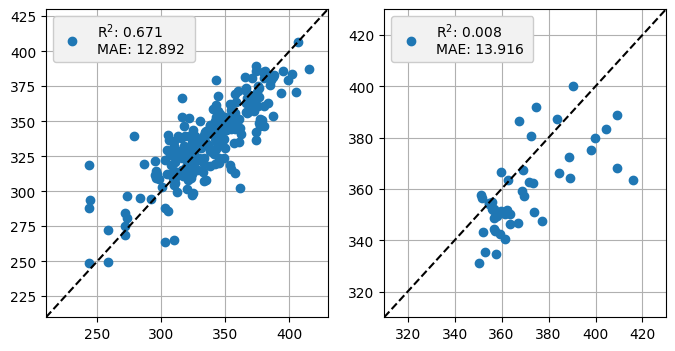

In [32]:
f, axs = plt.subplots(1,2,figsize=(8,4))
plot_scatter(axs[0], x1 + 273.15,  y1 + 273.15, xrange = [210, 430], fmts=['{:5.3f}','{:5.3f}'], metrics=['R2','MAE'])
plot_scatter(axs[1], x2 + 273.15,  y2 + 273.15, xrange = [310, 430], fmts=['{:5.3f}','{:5.3f}'], metrics=['R2','MAE'])
#f.savefig('./figs/output.xgb.test.pdf')

### SVR

In [20]:
outputs_svr = {}
for ftyp, (feat, test_feat) in features.items():
    output = {}
    for i in range(5):
        m_best = -50
        train_idx, valid_idx = cv[i]
        x_train = feat[train_idx]
        x_valid = feat[valid_idx]
        y_train = train_tgt[train_idx]
        y_valid = train_tgt[valid_idx]
        for kernel in ['linear']:
            bo = BayesianOptimization(svr_obj_fnc1, pbounds={'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=140)
        for kernel in ['sigmoid','poly']:
            bo = BayesianOptimization(svr_obj_fnc2, pbounds={'coef':[0,10], 'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=140)
        print('Fold: {} : {:10s} | {:10s} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f}'.format(i, ftyp, best['params']['kernel'], *best['measure']))
        output[i] = best.copy()
    outputs_svr[ftyp] = output

with open('../outputs/results/baseline/svr.gg.output.pkl','wb') as f:
    pickle.dump(outputs_svr, f)

Fold: 0 : graph      | poly       |   0.368 /  17.762 |   0.454 /  17.586 |  -1.040 /  18.684
Fold: 1 : graph      | poly       |   0.412 /  17.484 |   0.400 /  18.504 |  -0.863 /  18.146
Fold: 2 : graph      | poly       |   0.392 /  18.590 |   0.354 /  16.576 |  -1.136 /  19.591
Data point [1.e+02 1.e+01 1.e-03] is not unique. 1 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 2 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 3 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 4 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 5 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 6 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 7 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 8 duplicates registered. Continuing ...
Data p

In [16]:
with open('../outputs/results/baseline/svr.gg.output.pkl','rb') as f:
    outputs_svr = pickle.load(f)
    
for key, output in outputs_svr.items():
    for i, out in output.items():
        print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array(out['measure'])))
    print('-'*80)
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).mean(0)))
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).std(0)))
    print('-'*80)

    x1 = np.hstack([v['valid'][0].reshape(-1) for v in output.values()])
    y1 = np.hstack([v['valid'][1].reshape(-1) for v in output.values()])
    x2 = output[0]['test'][0].reshape(-1)
    y2 = np.mean([v['test'][1].reshape(-1) for v in output.values()], 0)
    print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))
    print()

  0.368   17.762 /   0.454  17.586 /  -1.040  18.684
  0.412   17.484 /   0.400  18.504 /  -0.863  18.146
  0.392   18.590 /   0.354  16.576 /  -1.136  19.591
  0.405   16.845 /   0.395  21.019 /  -0.954  18.723
  0.419   18.141 /   0.234  17.402 /  -1.119  19.210
--------------------------------------------------------------------------------
  0.399   17.764 /   0.367  18.218 /  -1.022  18.871
  0.018    0.591 /   0.074   1.529 /   0.103   0.493
--------------------------------------------------------------------------------
                 /   0.392  18.218 /  -1.014  18.797

  0.805    8.377 /   0.478  15.503 /  -0.017  13.253
  0.807    8.580 /   0.659  12.531 /  -0.019  13.144
  0.751   10.536 /   0.506  15.654 /   0.325  11.120
  0.815    8.669 /   0.728  12.121 /   0.149  12.287
  0.799   10.227 /   0.677  11.087 /   0.076  13.169
--------------------------------------------------------------------------------
  0.795    9.278 /   0.610  13.379 /   0.103  12.595
  0.023    0.9

## RDKit fingreprints

### Data load

In [25]:
df_train = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.train.csv')
df_test = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.test.csv')
cv = CrossValidation(n_fold=5, n_data=df_train.shape[0], return_index=True)

In [28]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

col_sm = [f'SMILES_{x}' for x in 'ABCDE']
col_fr = [f'FR_{x}' for x in 'ABCDE']

all_smiles = np.unique(np.vstack([df_train[col_sm], df_test[col_sm]]).reshape(-1))
fps = {}
for s in all_smiles:
    fps[s] = {}
    m = Chem.MolFromSmiles(s)
    arr = np.zeros((0,), dtype=np.int8)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=256)
    fp2 = AllChem.GetHashedAtomPairFingerprintAsBitVect(m, nBits=256)
    fp3 = AllChem.GetMACCSKeysFingerprint(m)
    for name, fp in zip(['morgan','pair','maccs'], [fp1, fp2, fp3]):
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps[s][name] = arr.astype(float).copy()
        
def get_data(df, fptype='morgan'):
    global col_sm, col_fr, fps
    feats = []
    for i, row in df.iterrows():
        feat_fr = []
        feat_orig = []
        w = row[col_fr].sum()
        for smiles, fr in zip(row[col_sm], row[col_fr]):
            if fr == 0: continue
            fp = fps[smiles][fptype].copy()
            feat_orig.append(fp)
            feat_fr.append(fp.astype(float) * fr/w)
        feats.append(np.hstack([np.sum(feat_orig, 0), np.sum(feat_fr, 0)]))
    return np.array(feats), df.TG.values.reshape(-1,1)

### XGBoost

In [36]:
outputs_xgb = {}
for fp_type in ['morgan','pair','maccs']:
    output = {}
    train_feat, train_tgt = get_data(df_train, fptype=fp_type)
    test_feat, test_tgt = get_data(df_test, fptype=fp_type)
    for i in range(5):
        train_idx, valid_idx = cv[i]
        train_data = xgb.DMatrix(train_feat[train_idx], train_tgt[train_idx])
        valid_data = xgb.DMatrix(train_feat[valid_idx], train_tgt[valid_idx])
        test_data = xgb.DMatrix(test_feat, test_tgt)
        m_best = -1e5
        bo = BayesianOptimization(xgb_obj_fnc, pbounds={'eta':[1e-2,10], 'max_depth':[1,20]},
                                  random_state=100, verbose=0)
        bo.maximize(init_points=10, n_iter=140)
        tt, tp = best['train']
        vt, vp = best['valid']
        ft, fp = best['test']
        vals = [
            r2_score(tt, tp), np.sqrt(mean_squared_error(tt, tp)), mean_absolute_error(tt, tp),
            r2_score(vt, vp), np.sqrt(mean_squared_error(vt, vp)), mean_absolute_error(vt, vp),
            r2_score(ft, fp), np.sqrt(mean_squared_error(ft, fp)), mean_absolute_error(ft, fp)
        ]
        print('Fold: {} : {:10s} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(i, fp_type, *vals))
        output[i] = best.copy()
    outputs_xgb[fp_type] = output
#    print('-'*70)
#    print('AVG:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.mean(vals, axis=0)))
#    print('STD:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.std(vals, axis=0)))
with open('../outputs/results/baseline/xgb.fp.output.pkl','wb') as f:
    pickle.dump(outputs_xgb, f)

Fold: 0 : morgan     |   1.000 /  0.67 /  0.46 |   0.612 / 16.04 / 11.05 |   0.083 / 16.56 / 13.58 | 
Fold: 1 : morgan     |   0.994 /  2.31 /  1.56 |   0.683 / 19.46 / 13.71 |   0.060 / 16.77 / 14.01 | 
Fold: 2 : morgan     |   1.000 /  0.50 /  0.28 |   0.627 / 18.38 / 11.71 |   0.156 / 15.88 / 12.90 | 
Fold: 3 : morgan     |   1.000 /  0.61 /  0.37 |   0.863 / 12.60 / 10.01 |  -0.070 / 17.89 / 14.34 | 
Fold: 4 : morgan     |   0.991 /  3.00 /  2.22 |   0.756 / 14.02 / 11.53 |   0.295 / 14.52 / 11.19 | 
Fold: 0 : pair       |   0.998 /  1.58 /  0.87 |   0.576 / 16.78 / 11.57 |  -0.414 / 20.56 / 15.83 | 
Fold: 1 : pair       |   0.999 /  1.02 /  0.61 |   0.569 / 22.68 / 17.10 |  -0.088 / 18.04 / 14.84 | 
Fold: 2 : pair       |   1.000 /  0.10 /  0.04 |   0.614 / 18.69 / 12.12 |  -0.302 / 19.74 / 14.56 | 
Fold: 3 : pair       |   0.995 /  2.03 /  1.50 |   0.855 / 12.97 /  9.32 |  -0.069 / 17.88 / 13.53 | 
Fold: 4 : pair       |   1.000 /  0.20 /  0.08 |   0.741 / 14.43 / 11.19 |  -0.632

In [37]:
with open('../outputs/results/baseline/xgb.fp.output.pkl','rb') as f:
    outputs_xgb = pickle.load(f)
    
for key, output in outputs_xgb.items():
    for i, out in output.items():
        print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array(out['measure'])))
    print('-'*80)
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).mean(0)))
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).std(0)))
    print('-'*80)

    x1 = np.hstack([v['valid'][0].reshape(-1) for v in output.values()])
    y1 = np.hstack([v['valid'][1].reshape(-1) for v in output.values()])
    x2 = output[0]['test'][0].reshape(-1)
    y2 = np.mean([v['test'][1].reshape(-1) for v in output.values()], 0)
    print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))
    print()    

  1.000    0.456 /   0.612  11.055 /   0.083  13.580
  0.994    1.558 /   0.683  13.711 /   0.060  14.011
  1.000    0.278 /   0.627  11.706 /   0.156  12.895
  1.000    0.371 /   0.863  10.009 /  -0.070  14.345
  0.991    2.222 /   0.756  11.529 /   0.295  11.190
--------------------------------------------------------------------------------
  0.997    0.977 /   0.708  11.602 /   0.105  13.204
  0.004    0.776 /   0.092   1.208 /   0.120   1.118
--------------------------------------------------------------------------------
                 /   0.720  11.602 /   0.375  11.305

  0.998    0.866 /   0.576  11.569 /  -0.414  15.829
  0.999    0.607 /   0.569  17.095 /  -0.088  14.837
  1.000    0.041 /   0.614  12.122 /  -0.302  14.557
  0.995    1.496 /   0.855   9.320 /  -0.069  13.530
  1.000    0.079 /   0.741  11.186 /  -0.632  15.657
--------------------------------------------------------------------------------
  0.998    0.618 /   0.671  12.258 /  -0.301  14.882
  0.002    0.5

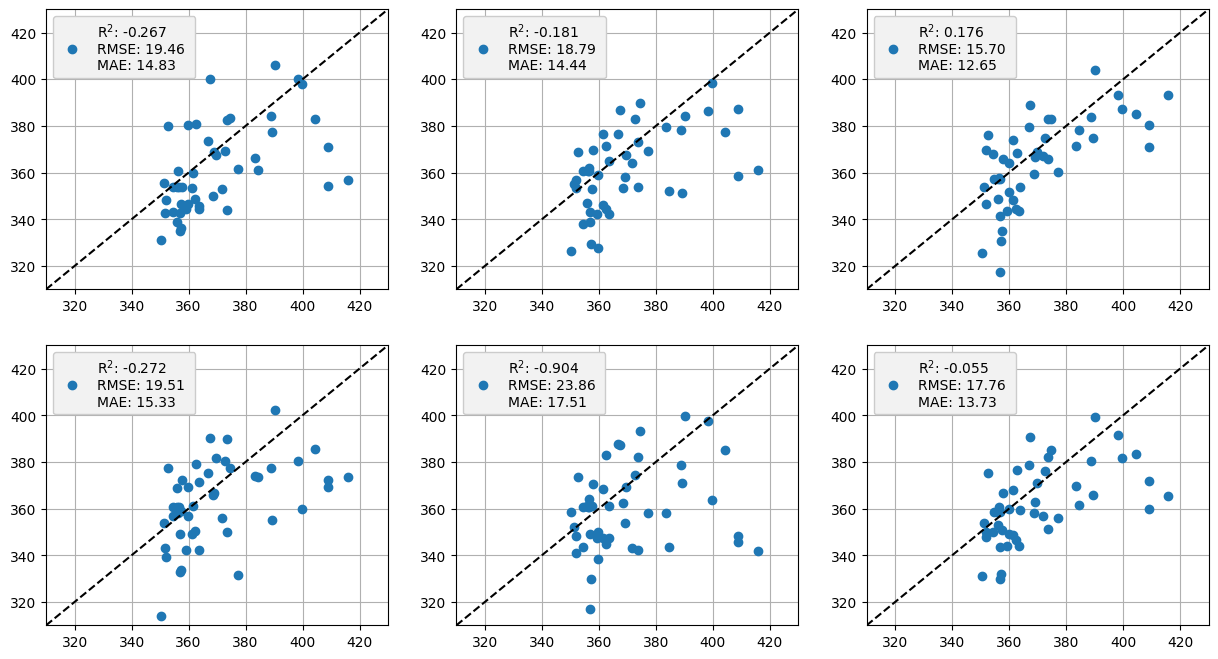

In [50]:
f, axs = plt.subplots(2,3,figsize=(15,8))
axs = axs.reshape(-1)
ys = []
for i in range(5):
    x0 = outputs_xgb['maccs'][i]['test'][0].reshape(-1) + 273.15
    y0 = outputs_xgb['maccs'][i]['test'][1].reshape(-1) + 273.15
    ys.append(y0)
    plot_scatter(axs[i], x0, y0, xrange=[310, 430], marker='o')
plot_scatter(axs[-1], x0, np.mean(ys, 0), xrange=[310,430], marker='o')
f.savefig('../../figs/output.xgb.test.pdf')

### SVR

In [31]:
outputs_svr = {}
for fp_type in ['morgan','pair','maccs']:
    output = {}
    train_feat, train_tgt = get_data(df_train, fptype=fp_type)
    test_feat, test_tgt = get_data(df_test, fptype=fp_type)
    for i in range(5):
        m_best = -50
        train_idx, valid_idx = cv[i]
        x_train = train_feat[train_idx]
        x_valid = train_feat[valid_idx]
        y_train = train_tgt[train_idx]
        y_valid = train_tgt[valid_idx]
        for kernel in ['linear']:
            bo = BayesianOptimization(svr_obj_fnc1, pbounds={'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=140)
        for kernel in ['sigmoid','poly']:
            bo = BayesianOptimization(svr_obj_fnc2, pbounds={'coef':[0,10], 'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=140)
        print('Fold: {} : {:10s} | {:10s} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f}'.format(i, fp_type, best['params']['kernel'], *best['measure']))
        output[i] = best.copy()
    outputs_svr[fp_type] = output

with open('../outputs/results/baseline/svr.fp.output.pkl','wb') as f:
    pickle.dump(outputs_svr, f)

Fold: 0 : morgan     | poly       |   0.929 /   4.046 |   0.657 /  11.335 |   0.425 /  10.795
Fold: 1 : morgan     | poly       |   0.938 /   2.588 |   0.664 /  15.943 |   0.104 /  12.871
Fold: 2 : morgan     | poly       |   0.917 /   4.557 |   0.602 /  11.695 |   0.437 /   9.727
Fold: 3 : morgan     | poly       |   0.900 /   3.425 |   0.828 /  10.162 |   0.416 /  10.239
Fold: 4 : morgan     | poly       |   0.913 /   3.370 |   0.658 /  12.406 |   0.478 /   9.700
Fold: 0 : pair       | poly       |   0.927 /   5.189 |   0.654 /  11.544 |   0.333 /  11.167
Fold: 1 : pair       | poly       |   0.943 /   2.699 |   0.672 /  15.711 |   0.277 /  11.294
Fold: 2 : pair       | poly       |   0.958 /   1.997 |   0.627 /  12.461 |   0.220 /  11.580
Fold: 3 : pair       | poly       |   0.934 /   3.095 |   0.793 /  11.126 |   0.484 /  10.100
Fold: 4 : pair       | poly       |   0.906 /   3.461 |   0.664 /  12.438 |   0.449 /   9.513
Fold: 0 : maccs      | poly       |   0.872 /   5.982 |   0.

In [39]:
with open('../outputs/results/baseline/svr.fp.output.pkl','rb') as f:
    outputs_svr = pickle.load(f)
    
for key, output in outputs_svr.items():
    print(key)
    for i, out in output.items():
        print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array(out['measure'])))
    print('-'*80)
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).mean(0)))
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).std(0)))
    print('-'*80)

    x1 = np.hstack([v['valid'][0].reshape(-1) for v in output.values()])
    y1 = np.hstack([v['valid'][1].reshape(-1) for v in output.values()])
    x2 = output[0]['test'][0].reshape(-1)
    y2 = np.mean([v['test'][1].reshape(-1) for v in output.values()], 0)
    print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))
    print()

morgan
  0.929    4.046 /   0.657  11.335 /   0.425  10.795
  0.938    2.588 /   0.664  15.943 /   0.104  12.871
  0.917    4.557 /   0.602  11.695 /   0.437   9.727
  0.900    3.425 /   0.828  10.162 /   0.416  10.239
  0.913    3.370 /   0.658  12.406 /   0.478   9.700
--------------------------------------------------------------------------------
  0.919    3.597 /   0.682  12.308 /   0.372  10.666
  0.013    0.667 /   0.077   1.957 /   0.136   1.173
--------------------------------------------------------------------------------
                 /   0.691  12.308 /   0.487   9.463

pair
  0.927    5.189 /   0.654  11.544 /   0.333  11.167
  0.943    2.699 /   0.672  15.711 /   0.277  11.294
  0.958    1.997 /   0.627  12.461 /   0.220  11.580
  0.934    3.095 /   0.793  11.126 /   0.484  10.100
  0.906    3.461 /   0.664  12.438 /   0.449   9.513
--------------------------------------------------------------------------------
  0.934    3.288 /   0.682  12.656 /   0.353  10.731
  

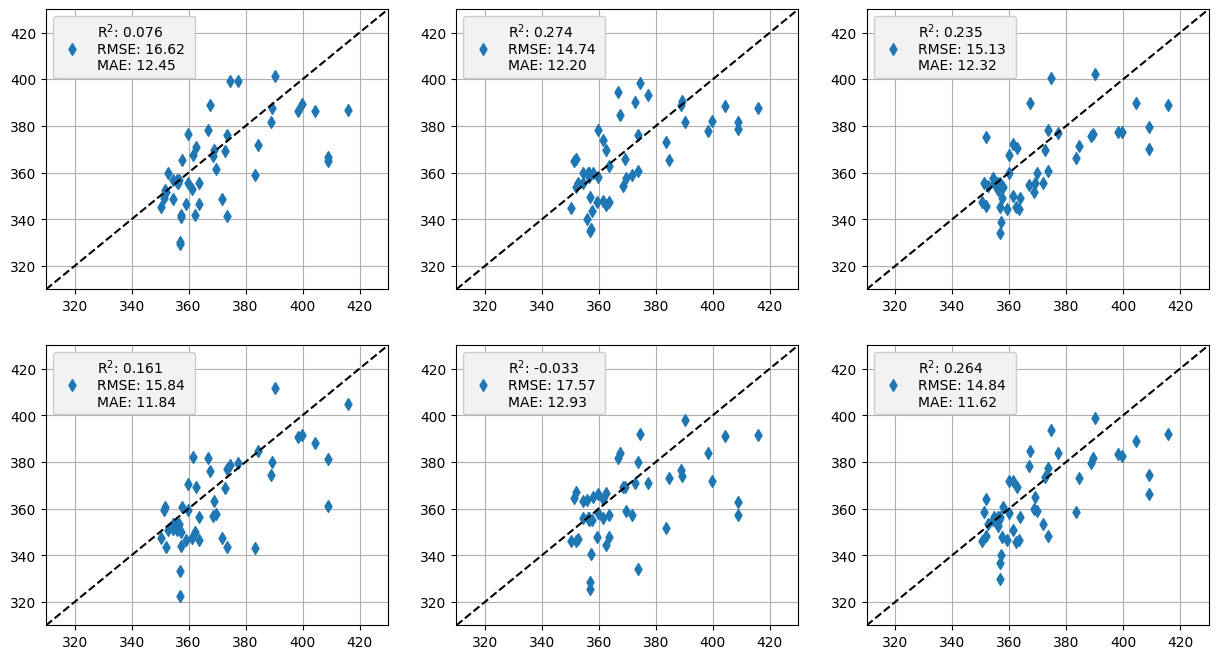

In [49]:
f, axs = plt.subplots(2,3,figsize=(15,8))
axs = axs.reshape(-1)
ys = []
for i in range(5):
    x0 = outputs_svr['maccs'][i]['test'][0].reshape(-1) + 273.15
    y0 = outputs_svr['maccs'][i]['test'][1].reshape(-1) + 273.15
    ys.append(y0)
    plot_scatter(axs[i], x0, y0, xrange=[310, 430], marker='d')
plot_scatter(axs[-1], x0, np.mean(ys, 0), xrange=[310,430], marker='d')
f.savefig('../../figs/output.svr.test.pdf')

## GPR

In [57]:
outputs_gpr = {}
for fp_type in ['morgan','pair','maccs']:
    output = {}
    train_feat, train_tgt = get_data(df_train, fptype=fp_type)
    test_feat, test_tgt = get_data(df_test, fptype=fp_type)
    for i in range(5):
        m_best = -50
        train_idx, valid_idx = cv[i]
        x_train = train_feat[train_idx]
        x_valid = train_feat[valid_idx]
        y_train = train_tgt[train_idx]
        y_valid = train_tgt[valid_idx]
        bo = BayesianOptimization(gpr_obj_fnc, pbounds={'alpha':[-10,2], 'n':[0,10]},
                                  random_state=100, verbose=0, allow_duplicate_points=True)
        bo.maximize(init_points=10, n_iter=140)
        print('Fold: {} : {:10s} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f}'.format(i, fp_type, *best['measure']))
        output[i] = best.copy()
    outputs_svr[fp_type] = output

with open('../outputs/results/baseline/gpr.fp.output.pkl','wb') as f:
    pickle.dump(outputs_svr, f)

Fold: 0 : morgan     |   0.988 /   1.516 |  -2.244 /  42.598 | -17.731 /  61.993
Fold: 1 : morgan     |   0.990 /   0.917 |  -2.328 /  47.211 | -15.513 /  56.511
Fold: 2 : morgan     |   0.984 /   2.709 |  -2.552 /  47.084 | -16.575 /  59.485
Fold: 3 : morgan     |   0.985 /   1.947 |  -2.893 /  46.829 | -17.352 /  61.853
Fold: 4 : morgan     |   0.999 /   0.419 |  -1.222 /  42.805 | -16.937 /  60.314
Fold: 0 : pair       |   0.997 /   0.989 |  -2.914 /  50.573 | -19.549 /  68.200
Fold: 1 : pair       |   0.996 /   0.692 |  -2.535 /  50.568 | -18.256 /  66.324
Fold: 2 : pair       |   0.994 /   0.727 |  -3.179 /  52.720 | -18.887 /  67.679
Fold: 3 : pair       |   0.990 /   1.855 |  -3.695 /  54.537 | -19.694 /  69.875
Fold: 4 : pair       |   1.000 /   0.000 |  -1.489 /  47.404 | -19.007 /  67.323
Fold: 0 : maccs      |   0.953 /   3.365 |  -0.815 /  26.574 | -13.462 /  50.336
Fold: 1 : maccs      |   0.947 /   3.314 |  -1.277 /  35.048 | -12.486 /  47.071
Fold: 2 : maccs      |   0.9